# Question 3

## Can university rankings be accurately predicted using parameters from another ranking agency, or are they highly agency-specific?

In [ ]:
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, median_absolute_error
from dotenv import load_dotenv
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from dbrepo.RestClient import RestClient

In [ ]:
QS_DATA_PID = "e29de789-357e-41a0-962a-03fc5ea8e45b"
ARWU_DATA_PID = "a8e9d713-7ee9-45b1-b00d-9fb01f5d01de"
THE_DATA_PID = "488f5814-1c24-4ddc-bb7c-175e4ed5cc8c"

In [ ]:
def get_data_from_dbrepo(data_pid):
    """
    Fetch data from DBRepo using the provided data PID.
    """
    # Initialize the RestClient with your credentials
    load_dotenv(dotenv_path='.env')
    passwd = os.getenv("PASSWD")
    usr = os.getenv("USERNAME")
    client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at", username=usr, password=passwd)
    
    # Fetch the data
    df = client.get_identifier_data(identifier_id=data_pid)
    
    return df

Create cleaning data cleaning functions to reuse

In [ ]:
# Convert 'Rank' values like "1001-1200" to the midpoint value
def convert_rank_to_number(rank):
    if pd.isnull(rank):
        return None  # Keep NaNs as they might be handled separately
    if isinstance(rank, float):  # Check if the ratio is already a float
        return rank
    if isinstance(rank, int):  # Check if the ratio is already a float
        return rank
    try:
        if "-" in str(rank):  # If rank is in range format "1001-1200"
            low, high = map(int, rank.split("-"))
            return (low + high) // 2  # Take the midpoint value
        if "+" in str(rank):  # If rank is in format "1001+"
            return int(rank[:-1])  # Remove '+' and convert to integer
        if "%" in str(rank):  # If rank is like 60% return 0.6
            return float(rank[:-1]) / 100
        if  rank == "S":
            return 0
        if  rank == "M":
            return 1
        if  rank == "L":
            return 2
        if  rank == "XL":
            return 3
        return int(rank)  # Convert single-value ranks to integers
    except:
        return None  # Handle unexpected formats

In [ ]:
# Convert 'Female to Male Ratio' from "x : y" format to float (x / y)
# If the value is null, replace it with 0.5

def convert_ratio_to_float(ratio):
    if isinstance(ratio, float):  # Check if the ratio is already a float
        return ratio
    if pd.isnull(ratio):  # Handle missing values
        return 0.5
    try:
        x, y = map(float, ratio.split(":"))
        return x / (y+x)
    except:
        return 0.5  # Fallback if conversion fails

In [ ]:
# Convert Percentage to Float
def convert_percentage_to_float(percentage):
    if pd.isnull(percentage):  # Handle missing values
        return 0
    if isinstance(percentage, float):  # Check if the ratio is already a float
        return percentage
    try:
        if "%" in str(percentage):  # If rank is like 60% return 0.6
            return float(percentage[:-1]) / 100
    except:
        return 0  # Handle unexpected formats

In [ ]:
# Handles the weird Female to male ratio in the RHE dataset
def clean_ratio(value):
    if pd.isna(value):
        return None  # Keep missing values as None (or handle separately)
    if isinstance(value, str) and ':' in value:  # Case: "47:53"
        try:
            values = value.split(':')
            female, male= map(float, values[0:2])
            return female / (female + male)  # Convert to decimal
        except ValueError:
            return None  # Handle unexpected cases
    elif isinstance(value, (int, float)):  # Case: Already a decimal
        return value
    else:
        return None  # Handle unexpected cases

## Getting Ranking Data
### QS Ranking data

In [ ]:
df_QS = get_data_from_dbrepo(QS_DATA_PID)
df_QS

In [ ]:
df_QS.info()

Columns that need to be converted to number:
- 2025 Rank
- 2024 Rank
- Size
- QS Overall Score


In [ ]:
df_QS["2025_rank"] = df_QS["2025_rank"].apply(convert_rank_to_number)
df_QS["2024_rank"] = df_QS["2024_rank"].apply(convert_rank_to_number)
df_QS["size"] = df_QS["size"].apply(convert_rank_to_number)
df_QS["qs_overall_score"] = df_QS["qs_overall_score"].apply(convert_rank_to_number)
df_QS.info()

In [ ]:
missing_cols = df_QS.columns[df_QS.isnull().any()].tolist()
missing_cols

In [ ]:
df_QS.drop(columns=["2025_rank"], inplace=True) # Only 2024 Data is needed
df_QS.drop(columns=["qs_overall_score"], inplace=True) # is missing in most rows
df_QS.dropna(subset=["2024_rank"], inplace=True)

df_QS["international_faculty"] = df_QS["international_faculty"].fillna(0)
df_QS["international_students"] = df_QS["international_students"].fillna(0)
df_QS["sustainability"] = pd.to_numeric(df_QS["sustainability"], errors="coerce")
df_QS["sustainability"] = df_QS["sustainability"].fillna(df_QS["sustainability"].median())
df_QS["international_research_network"] = pd.to_numeric(df_QS["international_research_network"], errors="coerce")
df_QS["international_research_network"] = df_QS["international_research_network"].fillna(df_QS["international_research_network"].median())
df_QS.columns[df_QS.isnull().any()].tolist()



### THE World University Rankings 2016-2025

In [ ]:
df_THE = get_data_from_dbrepo(THE_DATA_PID)
df_THE

In [ ]:
df_THE.info()

 Columns that need to be converted to number:
 - International Students
 - Female to Male Ratio

In [ ]:
df_THE["international_students"] = df_THE["international_students"].apply(convert_percentage_to_float)
df_THE['female_to_male_ratio'] = df_THE['female_to_male_ratio'].apply(clean_ratio)
df_THE.info()

In [ ]:
missing_cols = df_THE.columns[df_THE.isnull().any()].tolist()
missing_cols

In [ ]:
df_THE['female_to_male_ratio'] = df_THE['female_to_male_ratio'].fillna(0.5) # Fill missing values with 0.5



### ARWU Dataset

In [ ]:
df_ARWU = get_data_from_dbrepo(ARWU_DATA_PID)
df_ARWU.info()

 Columns that need to be converted to number:
- Rank
- National/Regional Rank

In [ ]:
df_ARWU["rank"] = df_ARWU["rank"].apply(convert_rank_to_number)
df_ARWU["national_or_regional_rank"] = df_ARWU["national_or_regional_rank"].apply(convert_rank_to_number)
df_ARWU

In [ ]:
# get columns with missing values
df_ARWU.columns[df_ARWU.isnull().any()].tolist()

In [ ]:
# only 2 missing rows, we use median to fill missing values
df_ARWU["ns"] = pd.to_numeric(df_ARWU["ns"], errors="coerce")
df_ARWU["ns"] = df_ARWU["ns"].fillna(df_ARWU["ns"].median()) # Fill missing values with median
df_ARWU.columns[df_ARWU.isnull().any()].tolist()

## University Name Matching

Since the rankings use different names for the universities, we need to use some algorithms to match the datasets

In [ ]:

# Standardizing University Names Across Datasets
df_ARWU["name"] = df_ARWU["university_name"].str.lower().str.strip()
df_QS["name"] = df_QS["institution_name"].str.lower().str.strip()
df_THE["name"] = df_THE["name"].str.lower().str.strip()

# Step 1: Match ARWU with QS
vectorizer = TfidfVectorizer().fit_transform(df_ARWU["name"].tolist() + df_QS["name"].tolist())
cosine_sim = cosine_similarity(vectorizer)

# Find Closest Matches
matches_ARWU_QS = {
    df_ARWU["name"].iloc[i]: df_QS["name"].iloc[np.argmax(cosine_sim[i, len(df_ARWU["name"]):])]
    for i in range(len(df_ARWU))
}

# Merge ARWU and QS
df_ARWU["matched_name_qs"] = df_ARWU["name"].map(matches_ARWU_QS)
df_merged_AQ = df_ARWU.merge(df_QS, left_on="matched_name_qs", right_on="name", how="left", suffixes=("_arwu", "_qs"))

# Step 2: Match ARWU+QS with THE
vectorizer = TfidfVectorizer().fit_transform(df_merged_AQ["name_arwu"].tolist() + df_THE["name"].tolist())
cosine_sim = cosine_similarity(vectorizer)

matches_AQ_THE = {
    df_merged_AQ["name_arwu"].iloc[i]: df_THE["name"].iloc[np.argmax(cosine_sim[i, len(df_merged_AQ["name_arwu"]):])]
    for i in range(len(df_merged_AQ))
}

# Merge ARWU+QS with THE
df_merged_AQ["matched_name_the"] = df_merged_AQ["name_arwu"].map(matches_AQ_THE)
df_final = df_merged_AQ.merge(df_THE, left_on="matched_name_the", right_on="name", how="left", suffixes=("", "_the"))

# Drop Helper Columns
df_final = df_final.drop(columns=["matched_name_qs", "matched_name_the"])



In [ ]:
missing_cols = df_final.columns[df_final.isnull().any()].tolist()
missing_cols

In [ ]:
df_final.columns

In [ ]:
# rename columns and drop not needed columns
df_final['rank_qs'] = df_final['2024_rank']
df_final['rank_arwu'] = df_final['rank']
df_final = df_final.drop(['2024_rank',  "name_arwu", 'name_qs', 'name', 'year', 'rank'], axis=1)

Now we create lists with the columns from each ranking
As well as a list of suitible parameters for a regression model

In [ ]:

arwuList = ['rank_arwu', 'university_name', 'national_regional_rank', 'alumni', 'award', 'hici', 'n_s', 'pub', 'pcp']
qsList = ['rank_qs', 'institution_name', 'location', 'location_full', 'size',
       'academic_reputation', 'employer_reputation', 'faculty_student',
       'citations_per_faculty', 'international_faculty',
       'international_students', 'international_research_network',
       'employment_outcomes', 'sustainability', 'qs_overall_score',]
theList = ['name', 'country', 'student_population', 'students_to_staff_ratio', 'international_students_the',
           'female_to_male_ratio', 'overall_score', 'teaching', 'research_environment', 'research_quality', 'industry_impact', 'international_outlook']



In [ ]:
# rename columns to identify them in the combined dataset
r = df_final.rename(columns={col: col + '_arwu' for col in arwuList if not col.endswith('_arwu')}, inplace=True)
df_final.rename(columns={col: col + '_qs' for col in qsList if not col.endswith('_qs')}, inplace=True)
df_final.rename(columns={col: col + '_the' for col in theList if not col.endswith('_the')}, inplace=True)
df_final.columns

In [ ]:
# list of parameters for model training and prediction
listOfParameters = ['university_name_arwu', 'national_or_regional_rank', 'alumni_arwu',
       'award_arwu', 'hici_arwu', 'ns', 'pub_arwu', 'pcp_arwu',
       'institution_name_qs', 'location_qs', 'location_full_qs', 'size_qs',
       'academic_reputation_qs', 'employer_reputation_qs',
       'faculty_student_qs', 'citations_per_faculty_qs',
       'international_faculty_qs', 'international_students_qs',
       'international_research_network_qs', 'employment_outcomes_qs',
       'sustainability_qs', 'rank_the', 'country_the',
       'student_population_the', 'students_to_staff_ratio_the',
       'international_students_the', 'female_to_male_ratio_the',
       'overall_score_the', 'teaching_the', 'research_environment_the',
       'research_quality_the', 'industry_impact_the',
       'international_outlook_the', 'rank_qs', 'rank_arwu']

columnsNotSuitableForModelBuiliding = [
    'university_name_arwu', 'institution_name_qs', 'name_the',
    'country_the', 'location_qs', 'location_full_qs',
    'rank_qs', 'rank_arwu', 'rank_the', 'overall_score_the'
]

listOfParameters= list(set(listOfParameters) - set(columnsNotSuitableForModelBuiliding))

## Define functions to build and visualize models
We create a function which builds three models, one for each ranking dataset.
We can now train these models, using only the dataset from one ranking.
We do this to find out, if we can predict the ranking of universitys in all three ranking system but only using the dataset from one ranking

In [ ]:
import os
import json
import pandas as pd
import joblib

def build_models_and_save(df, parameters, save_path="model_outputs", filename_prefix="none_"):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error, r2_score,
        mean_absolute_percentage_error, explained_variance_score,
        median_absolute_error
    )

    # Create output directory
    os.makedirs(save_path, exist_ok=True)

    # Define the target columns for each ranking system
    ranking_targets = {
        "ARWU": "rank_arwu",
        "QS": "rank_qs",
        "THE": "rank_the"
    }

    models = {}
    overfitting_results = {}

    for ranking_name, target_column in ranking_targets.items():
        if target_column not in df.columns:
            continue

        y = df[target_column].dropna()
        X = df.loc[y.index, parameters]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize features
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize models
        lin_reg = LinearRegression()
        rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

        # Train models
        lin_reg.fit(X_train_scaled, y_train)
        rf_reg.fit(X_train_scaled, y_train)

        # Predictions
        y_train_pred_lin = lin_reg.predict(X_train_scaled)
        y_train_pred_rf = rf_reg.predict(X_train_scaled)
        y_test_pred_lin = lin_reg.predict(X_test_scaled)
        y_test_pred_rf = rf_reg.predict(X_test_scaled)

        # Evaluation metrics
        metrics = {
            "Linear Regression": {
                "Train MAE": mean_absolute_error(y_train, y_train_pred_lin),
                "Test MAE": mean_absolute_error(y_test, y_test_pred_lin),
                "Train MSE": mean_squared_error(y_train, y_train_pred_lin),
                "Test MSE": mean_squared_error(y_test, y_test_pred_lin),
                "Train R²": r2_score(y_train, y_train_pred_lin),
                "Test R²": r2_score(y_test, y_test_pred_lin),
                "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred_lin),
                "Test MAPE": mean_absolute_percentage_error(y_test, y_test_pred_lin),
                "Train EVS": explained_variance_score(y_train, y_train_pred_lin),
                "Test EVS": explained_variance_score(y_test, y_test_pred_lin),
                "Train MedAE": median_absolute_error(y_train, y_train_pred_lin),
                "Test MedAE": median_absolute_error(y_test, y_test_pred_lin),
            },
            "Random Forest": {
                "Train MAE": mean_absolute_error(y_train, y_train_pred_rf),
                "Test MAE": mean_absolute_error(y_test, y_test_pred_rf),
                "Train MSE": mean_squared_error(y_train, y_train_pred_rf),
                "Test MSE": mean_squared_error(y_test, y_test_pred_rf),
                "Train R²": r2_score(y_train, y_train_pred_rf),
                "Test R²": r2_score(y_test, y_test_pred_rf),
                "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred_rf),
                "Test MAPE": mean_absolute_percentage_error(y_test, y_test_pred_rf),
                "Train EVS": explained_variance_score(y_train, y_train_pred_rf),
                "Test EVS": explained_variance_score(y_test, y_test_pred_rf),
                "Train MedAE": median_absolute_error(y_train, y_train_pred_rf),
                "Test MedAE": median_absolute_error(y_test, y_test_pred_rf),
            }
        }

        # Save models
        model_filename = os.path.join(save_path, f"{filename_prefix}{ranking_name}_random_forest_model.pkl")
        joblib.dump(rf_reg, model_filename)

        # Save scaler
        scaler_filename = os.path.join(save_path, f"{filename_prefix}{ranking_name}_scaler.pkl")
        joblib.dump(scaler, scaler_filename)

        # Save metrics
        metrics_filename = os.path.join(save_path, f"{filename_prefix}{ranking_name}_metrics.json")
        with open(metrics_filename, "w") as f:
            json.dump(metrics, f, indent=4)

        # Save train and test data
        X_train_with_target = X_train.copy()
        X_train_with_target["target"] = y_train
        X_test_with_target = X_test.copy()
        X_test_with_target["target"] = y_test

        X_train_with_target.to_csv(os.path.join(save_path, f"{filename_prefix}{ranking_name}_train.csv"), index=False)
        X_test_with_target.to_csv(os.path.join(save_path, f"{filename_prefix}{ranking_name}_test.csv"), index=False)

        # Update result dictionaries
        overfitting_results[ranking_name] = metrics
        models[ranking_name] = rf_reg

    # Save full results summary
    df_overfitting_results = pd.DataFrame.from_dict({(i, j): overfitting_results[i][j]
                                                    for i in overfitting_results.keys()
                                                    for j in overfitting_results[i].keys()}, orient='index')
    df_overfitting_results.to_csv(os.path.join(save_path, f"{filename_prefix}full_overfitting_results.csv"))

    # Create basic README
    with open(os.path.join(save_path, f"{filename_prefix}README.md"), "w") as f:
        f.write("# Trained Models and Evaluation Results\n\n")
        f.write("This directory contains the trained Random Forest models for ARWU, QS, and THE rankings, along with their evaluation metrics, training and testing datasets.\n")
        f.write(f"Filename prefix used: `{filename_prefix}`\n")

    return df_overfitting_results, models


In [60]:
import os
import json
import pandas as pd
import joblib

def build_models(X_train, X_test, y_train_full, y_test_full, parameters, save_path="model_outputs", filename_prefix=""):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error, r2_score,
        mean_absolute_percentage_error, explained_variance_score,
        median_absolute_error
    )

    # Create output directory
    os.makedirs(save_path, exist_ok=True)

    # Target columns for each ranking system
    ranking_targets = {
        "ARWU": "rank_arwu",
        "QS": "rank_qs",
        "THE": "rank_the"
    }

    models = {}
    overfitting_results = {}

    for ranking_name, target_column in ranking_targets.items():
        if target_column not in y_train_full.columns or target_column not in y_test_full.columns:
            continue

        # Extract y_train and y_test for the current ranking
        y_train = y_train_full[target_column].dropna()
        y_test = y_test_full[target_column].dropna()

        # Align X with available targets
        X_train_aligned = X_train.loc[y_train.index, parameters]
        X_test_aligned = X_test.loc[y_test.index, parameters]

        # Standardize features
        scaler = StandardScaler().fit(X_train_aligned)
        X_train_scaled = scaler.transform(X_train_aligned)
        X_test_scaled = scaler.transform(X_test_aligned)

        # Initialize models
        lin_reg = LinearRegression()
        rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

        # Train models
        lin_reg.fit(X_train_scaled, y_train)
        rf_reg.fit(X_train_scaled, y_train)

        # Predictions
        y_train_pred_lin = lin_reg.predict(X_train_scaled)
        y_train_pred_rf = rf_reg.predict(X_train_scaled)
        y_test_pred_lin = lin_reg.predict(X_test_scaled)
        y_test_pred_rf = rf_reg.predict(X_test_scaled)

        # Evaluation metrics
        metrics = {
            "Linear Regression": {
                "Train MAE": mean_absolute_error(y_train, y_train_pred_lin),
                "Test MAE": mean_absolute_error(y_test, y_test_pred_lin),
                "Train MSE": mean_squared_error(y_train, y_train_pred_lin),
                "Test MSE": mean_squared_error(y_test, y_test_pred_lin),
                "Train R²": r2_score(y_train, y_train_pred_lin),
                "Test R²": r2_score(y_test, y_test_pred_lin),
                "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred_lin),
                "Test MAPE": mean_absolute_percentage_error(y_test, y_test_pred_lin),
                "Train EVS": explained_variance_score(y_train, y_train_pred_lin),
                "Test EVS": explained_variance_score(y_test, y_test_pred_lin),
                "Train MedAE": median_absolute_error(y_train, y_train_pred_lin),
                "Test MedAE": median_absolute_error(y_test, y_test_pred_lin),
            },
            "Random Forest": {
                "Train MAE": mean_absolute_error(y_train, y_train_pred_rf),
                "Test MAE": mean_absolute_error(y_test, y_test_pred_rf),
                "Train MSE": mean_squared_error(y_train, y_train_pred_rf),
                "Test MSE": mean_squared_error(y_test, y_test_pred_rf),
                "Train R²": r2_score(y_train, y_train_pred_rf),
                "Test R²": r2_score(y_test, y_test_pred_rf),
                "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred_rf),
                "Test MAPE": mean_absolute_percentage_error(y_test, y_test_pred_rf),
                "Train EVS": explained_variance_score(y_train, y_train_pred_rf),
                "Test EVS": explained_variance_score(y_test, y_test_pred_rf),
                "Train MedAE": median_absolute_error(y_train, y_train_pred_rf),
                "Test MedAE": median_absolute_error(y_test, y_test_pred_rf),
            }
        }

        # Save models
        model_filename = os.path.join(save_path, f"{filename_prefix}_data_{ranking_name}_target_random_forest_model.pkl")
        joblib.dump(rf_reg, model_filename)

        # Save scaler
        scaler_filename = os.path.join(save_path, f"{filename_prefix}_data_{ranking_name}_target_scaler.pkl")
        joblib.dump(scaler, scaler_filename)

        # # Save metrics
        # metrics_filename = os.path.join(save_path, f"{filename_prefix}_data_{ranking_name}_target_metrics.json")
        # with open(metrics_filename, "w") as f:
        #     json.dump(metrics, f, indent=4)

        # Update result dictionaries
        overfitting_results[ranking_name] = metrics
        models[ranking_name] = rf_reg

    # Save full results summary
    df_overfitting_results = pd.DataFrame.from_dict({(i, j): overfitting_results[i][j]
                                                    for i in overfitting_results.keys()
                                                    for j in overfitting_results[i].keys()}, orient='index')
    df_overfitting_results.to_csv(os.path.join(save_path, f"{filename_prefix}_full__results.csv"))
    
    return df_overfitting_results, models


In [ ]:
def visualize_results(df_overfitting_results, models, params):
    print(df_overfitting_results)

    # Store feature importances for each ranking system
    for name, model in models.items():
        feature_importance_results = {}

        rf_model = model
        ranking_name = name

            # Get feature importances
        feature_importance = rf_model.feature_importances_

        # Store in dictionary
        feature_importance_results[ranking_name] = pd.DataFrame({
            'Feature': params,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_results[ranking_name]['Feature'], feature_importance_results[ranking_name]['Importance'])
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title(f'Feature Importance - Random Forest ({ranking_name})')
        plt.gca().invert_yaxis()  # Highest importance on top
        plt.show()

        print(feature_importance_results)


In [57]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

save_path = "merged_data"
os.makedirs(save_path, exist_ok=True)

# Split into train and test data
y = df_final[["rank_arwu", "rank_qs", "rank_the"]]
X = df_final[listOfParameters]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save train and test data
X_train_with_target = pd.concat([X_train, y_train], axis=1)
X_test_with_target = pd.concat([X_test, y_test], axis=1)

X_train_with_target.to_csv(os.path.join(save_path, "university_rankings_merged_train_data.csv"), index=False)
X_test_with_target.to_csv(os.path.join(save_path, "university_rankings_merged_test_data.csv"), index=False)


## Using only the data from the ARWU ranking

                         Train MAE    Test MAE      Train MSE       Test MSE  \
ARWU Linear Regression  112.396925  120.569300   20777.157037   21904.355497   
     Random Forest       12.861150   39.577200     352.488485    3104.303606   
QS   Linear Regression  260.665426  272.071107  108606.036210  111948.189963   
     Random Forest       89.816262  243.708550   14487.897837   99975.504462   
THE  Linear Regression  262.643111  280.082018  121775.747255  122251.693046   
     Random Forest       92.946075  236.732600   17112.799401  108740.318781   

                        Train R²   Test R²  Train MAPE  Test MAPE  Train EVS  \
ARWU Linear Regression  0.751532  0.721448    2.763185   1.555749   0.751532   
     Random Forest      0.995785  0.960523    0.047312   0.126892   0.995795   
QS   Linear Regression  0.294895  0.259551    1.682267   2.913268   0.294895   
     Random Forest      0.905940  0.338741    0.518837   2.258658   0.905984   
THE  Linear Regression  0.296183  0.223

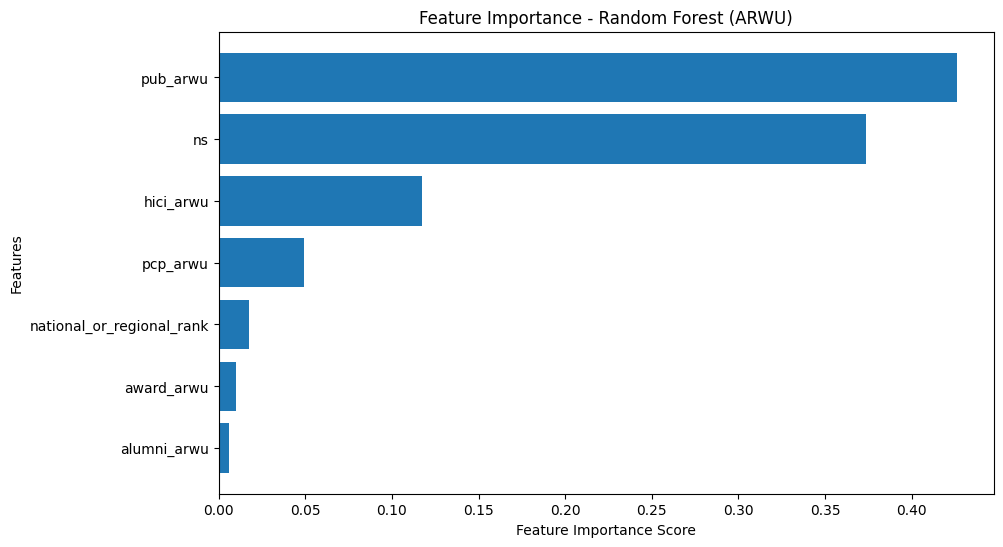

{'ARWU':                      Feature  Importance
2                   pub_arwu    0.426156
0                         ns    0.373823
4                  hici_arwu    0.117540
3                   pcp_arwu    0.049119
1  national_or_regional_rank    0.017519
5                 award_arwu    0.010122
6                alumni_arwu    0.005721}


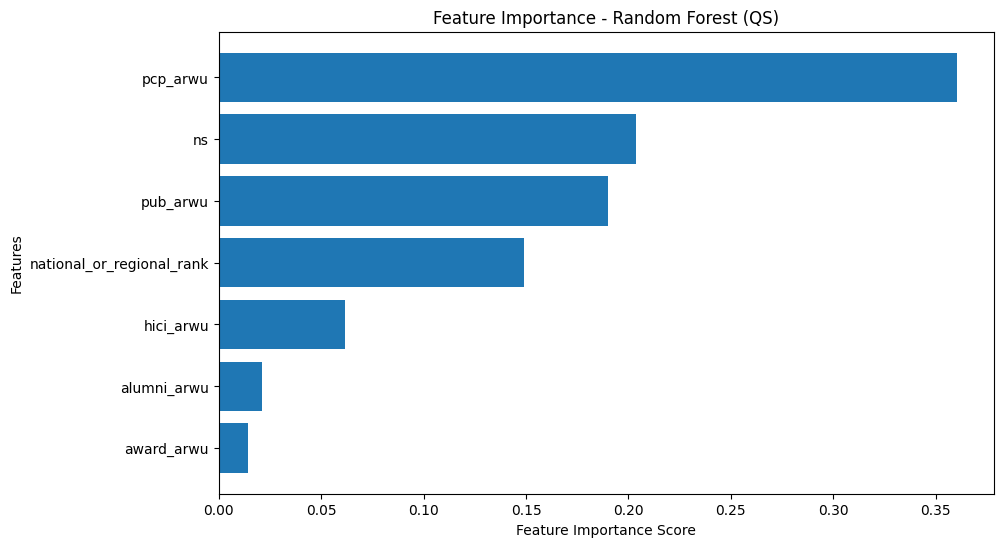

{'QS':                      Feature  Importance
3                   pcp_arwu    0.360297
0                         ns    0.203813
2                   pub_arwu    0.189776
1  national_or_regional_rank    0.148883
4                  hici_arwu    0.061485
6                alumni_arwu    0.021249
5                 award_arwu    0.014497}


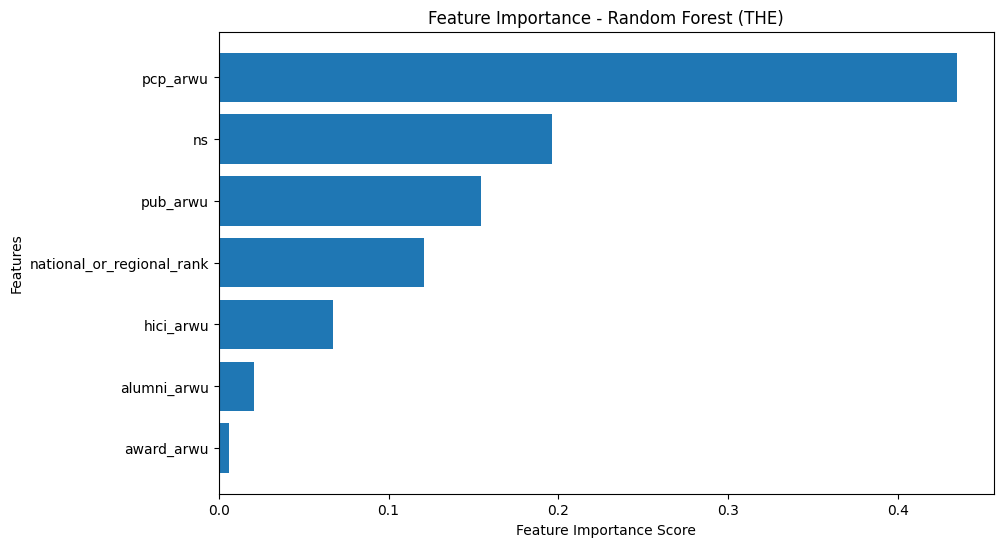

{'THE':                      Feature  Importance
3                   pcp_arwu    0.434648
0                         ns    0.196332
2                   pub_arwu    0.154130
1  national_or_regional_rank    0.121098
4                  hici_arwu    0.067184
6                alumni_arwu    0.020475
5                 award_arwu    0.006132}


In [61]:
paramsArwu = [col for col in listOfParameters if not (col.endswith('_the') or col.endswith('_qs'))]

resultsARWU, modelsARWU = build_models(X_train, X_test, y_train, y_test, paramsArwu, filename_prefix="arwu_")
visualize_results(resultsARWU, modelsARWU, paramsArwu)

### Insights
When using only the QS data the only model with good prediction results was the QS model, which conlcudes that no other ranking system can be predicted by using only the QS data

                         Train MAE    Test MAE      Train MSE       Test MSE  \
ARWU Linear Regression  144.873055  154.568713   32157.342668   34799.131728   
     Random Forest       28.372137   98.444900    1879.194637   21371.960460   
QS   Linear Regression  113.764253  123.233621   20234.951391   24813.033467   
     Random Forest       16.482250   47.017950     728.509484    6009.564559   
THE  Linear Regression  244.968781  251.531598  112318.621280  107704.163519   
     Random Forest       80.943699  206.884028   15689.763220   90850.608832   

                        Train R²   Test R²  Train MAPE  Test MAPE  Train EVS  \
ARWU Linear Regression  0.615439  0.557469    2.824187   1.856343   0.615439   
     Random Forest      0.977527  0.728219    0.093295   0.287395   0.977541   
QS   Linear Regression  0.868628  0.835881    1.159696   3.334696   0.868628   
     Random Forest      0.995270  0.960251    0.048932   0.153204   0.995279   
THE  Linear Regression  0.350842  0.316

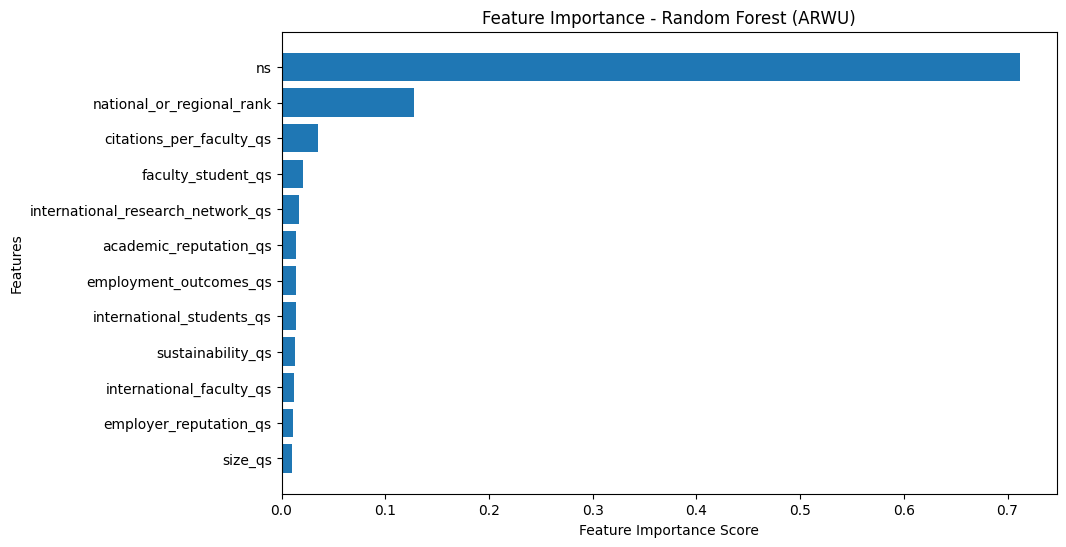

{'ARWU':                               Feature  Importance
2                                  ns    0.711652
5           national_or_regional_rank    0.127981
4            citations_per_faculty_qs    0.035459
3                  faculty_student_qs    0.020700
1   international_research_network_qs    0.016528
11             academic_reputation_qs    0.013852
8              employment_outcomes_qs    0.013743
6           international_students_qs    0.013533
7                   sustainability_qs    0.012791
10           international_faculty_qs    0.012184
0              employer_reputation_qs    0.011157
9                             size_qs    0.010421}


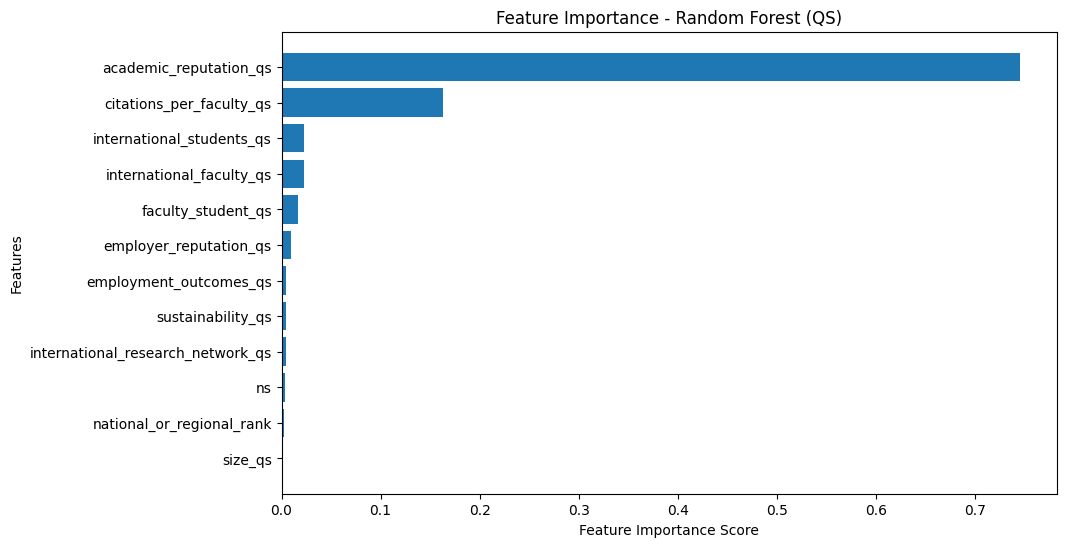

{'QS':                               Feature  Importance
11             academic_reputation_qs    0.745375
4            citations_per_faculty_qs    0.162908
6           international_students_qs    0.022949
10           international_faculty_qs    0.022407
3                  faculty_student_qs    0.016259
0              employer_reputation_qs    0.009214
8              employment_outcomes_qs    0.004865
7                   sustainability_qs    0.004619
1   international_research_network_qs    0.004353
2                                  ns    0.003305
5           national_or_regional_rank    0.002775
9                             size_qs    0.000971}


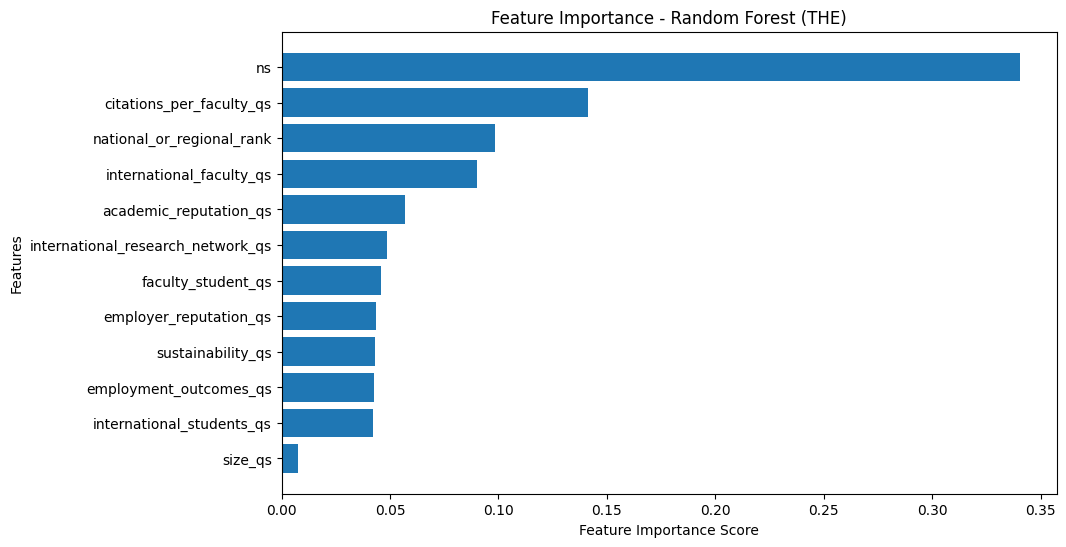

{'THE':                               Feature  Importance
2                                  ns    0.340247
4            citations_per_faculty_qs    0.141116
5           national_or_regional_rank    0.098209
10           international_faculty_qs    0.090154
11             academic_reputation_qs    0.056960
1   international_research_network_qs    0.048722
3                  faculty_student_qs    0.045904
0              employer_reputation_qs    0.043646
7                   sustainability_qs    0.042889
8              employment_outcomes_qs    0.042483
6           international_students_qs    0.041982
9                             size_qs    0.007687}


In [62]:
paramsQS = [col for col in listOfParameters if not (col.endswith('_the') or col.endswith('_arwu'))]

resultsQS, modelsQS = build_models(X_train, X_test, y_train, y_test, paramsQS, filename_prefix="qs_")
visualize_results(resultsQS, modelsQS, paramsQS)


### Insights
When using only the QS data the only model with good prediction results was the QS model, which conlcudes that no other ranking system can be predicted by using only the QS data

                         Train MAE    Test MAE     Train MSE      Test MSE  \
ARWU Linear Regression  137.778513  153.531241  29624.744382  36188.524647   
     Random Forest       27.502975   97.549600   1686.424583  20878.531913   
QS   Linear Regression  232.407018  244.200752  93990.580520  98776.721012   
     Random Forest       70.553012  188.531950  11231.361324  77003.389566   
THE  Linear Regression  102.283507  107.535867  18804.877698  23881.804936   
     Random Forest       16.128637   48.251650    804.830238  11609.869169   

                        Train R²   Test R²  Train MAPE  Test MAPE  Train EVS  \
ARWU Linear Regression  0.645726  0.539801    2.630186   1.790573   0.645726   
     Random Forest      0.979833  0.734493    0.089716   0.295311   0.979835   
QS   Linear Regression  0.389783  0.346670    1.410766   2.351481   0.389783   
     Random Forest      0.927082  0.490683    0.326924   0.801543   0.927098   
THE  Linear Regression  0.891315  0.848385    1.00493

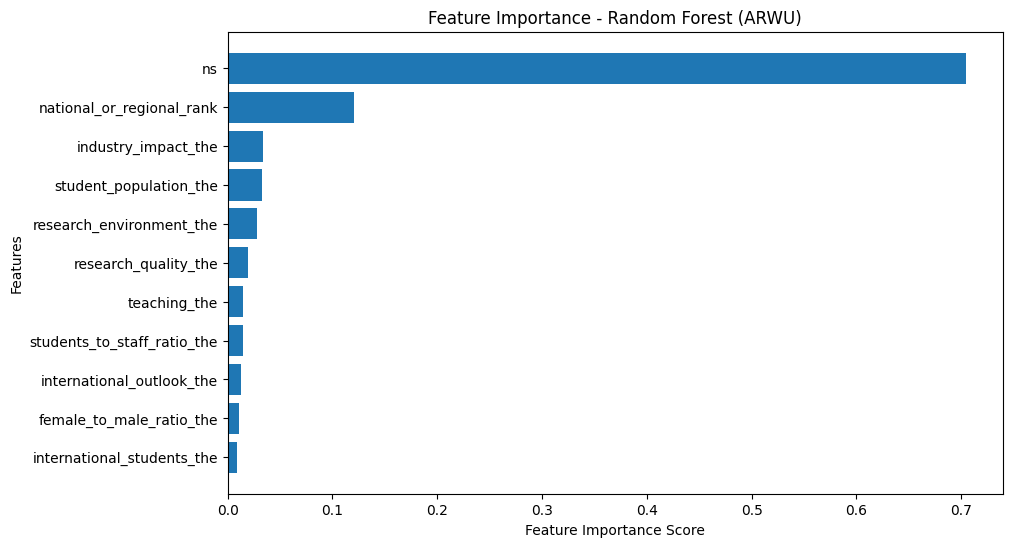

{'ARWU':                         Feature  Importance
3                            ns    0.704266
4     national_or_regional_rank    0.120577
5           industry_impact_the    0.034095
10       student_population_the    0.032480
6      research_environment_the    0.027583
1          research_quality_the    0.019707
2                  teaching_the    0.014456
0   students_to_staff_ratio_the    0.014268
9     international_outlook_the    0.012448
8      female_to_male_ratio_the    0.011170
7    international_students_the    0.008949}


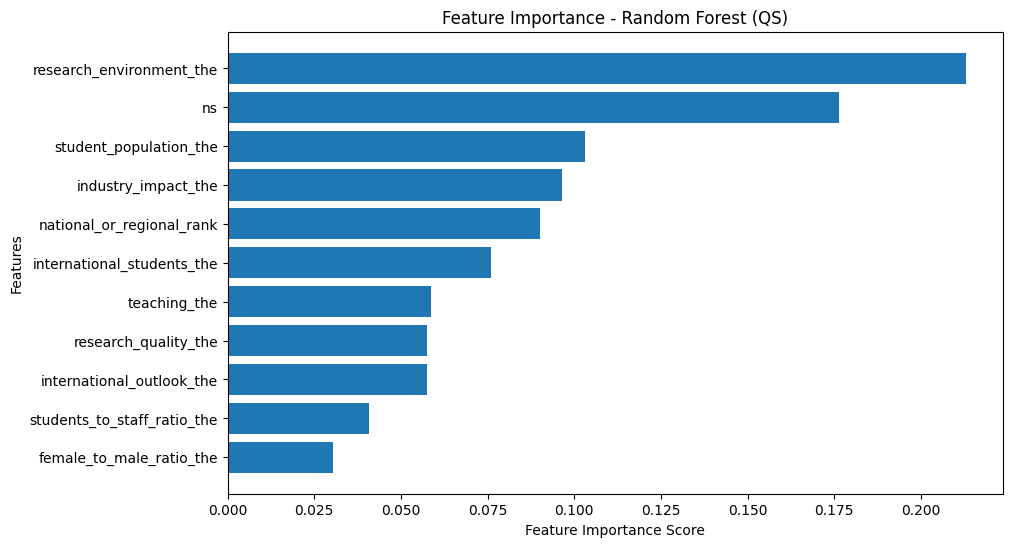

{'QS':                         Feature  Importance
6      research_environment_the    0.212939
3                            ns    0.176422
10       student_population_the    0.103226
5           industry_impact_the    0.096443
4     national_or_regional_rank    0.090071
7    international_students_the    0.076051
2                  teaching_the    0.058562
1          research_quality_the    0.057519
9     international_outlook_the    0.057496
0   students_to_staff_ratio_the    0.040885
8      female_to_male_ratio_the    0.030386}


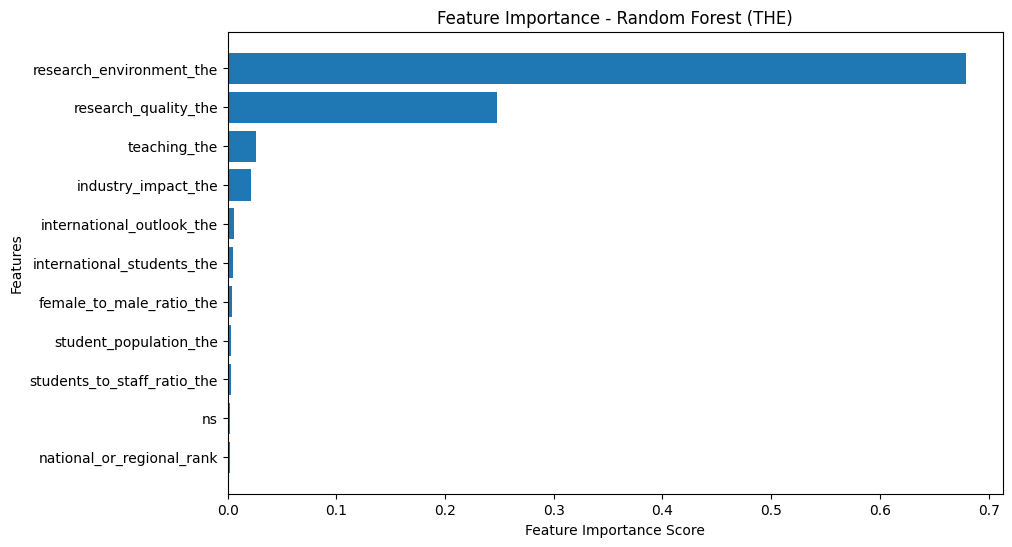

{'THE':                         Feature  Importance
6      research_environment_the    0.679007
1          research_quality_the    0.248232
2                  teaching_the    0.026303
5           industry_impact_the    0.021154
9     international_outlook_the    0.005704
7    international_students_the    0.004862
8      female_to_male_ratio_the    0.003975
10       student_population_the    0.003413
0   students_to_staff_ratio_the    0.002763
3                            ns    0.002326
4     national_or_regional_rank    0.002260}


In [63]:
paramsTHE = [col for col in listOfParameters if not (col.endswith('_arwu') or col.endswith('_qs'))]

resultsTHE, modelsTHE = build_models(X_train, X_test, y_train, y_test, paramsTHE, filename_prefix="the_")
visualize_results(resultsTHE, modelsTHE, paramsTHE)

### Insights
When using only the THE data the only model with good prediction results was the THE model, which conlcudes that no other ranking system can be predicted by using only the THE data

In [ ]:
results["Test R²"]["ARWU"]["Random Forest"],resultsARWU["Test R²"]["ARWU"]["Random Forest"],resultsQS["Test R²"]["ARWU"]["Random Forest"],resultsTHE["Test R²"]["ARWU"]["Random Forest"]
results["Test R²"]["QS"]["Random Forest"],resultsARWU["Test R²"]["QS"]["Random Forest"],resultsQS["Test R²"]["QS"]["Random Forest"],resultsTHE["Test R²"]["QS"]["Random Forest"]
results["Test R²"]["THE"]["Random Forest"],resultsARWU["Test R²"]["THE"]["Random Forest"],resultsQS["Test R²"]["THE"]["Random Forest"],resultsTHE["Test R²"]["THE"]["Random Forest"]


<Figure size 800x500 with 0 Axes>

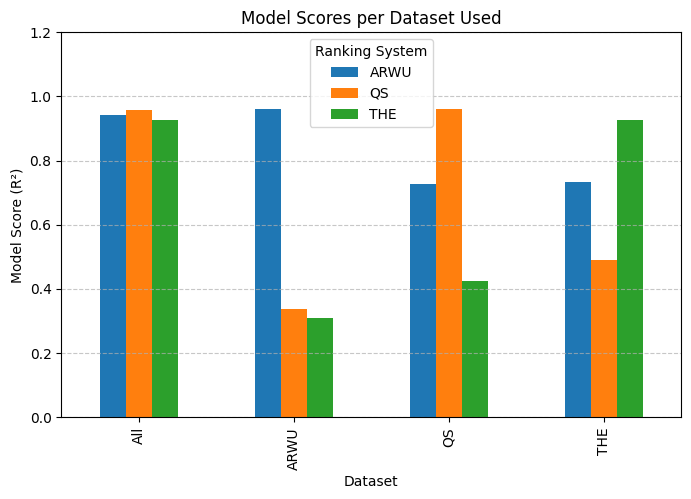

<Figure size 640x480 with 0 Axes>

In [65]:
results["Test R²"]
resultsARWU["Test R²"]
resultsQS["Test R²"]
resultsTHE["Test R²"]

data = {
    "Dataset": ["All", "ARWU", "QS", "THE"],
    "ARWU": [results["Test R²"]["ARWU"]["Random Forest"],resultsARWU["Test R²"]["ARWU"]["Random Forest"],resultsQS["Test R²"]["ARWU"]["Random Forest"],resultsTHE["Test R²"]["ARWU"]["Random Forest"]],
    "QS":   [results["Test R²"]["QS"]["Random Forest"],resultsARWU["Test R²"]["QS"]["Random Forest"],resultsQS["Test R²"]["QS"]["Random Forest"],resultsTHE["Test R²"]["QS"]["Random Forest"]],
    "THE":  [results["Test R²"]["THE"]["Random Forest"],resultsARWU["Test R²"]["THE"]["Random Forest"],resultsQS["Test R²"]["THE"]["Random Forest"],resultsTHE["Test R²"]["THE"]["Random Forest"]],
}

df_plot = pd.DataFrame(data)
# Plotting the bar chart
plt.figure(figsize=(8, 5))
df_plot.set_index("Dataset").plot(kind="bar", figsize=(8, 5))

plt.xlabel("Dataset")
plt.ylabel("Model Score (R²)")
plt.title("Model Scores per Dataset Used")
plt.ylim(0, 1.2)  # Adjusting Y-axis to match the given graph
plt.legend(title="Ranking System")
plt.grid(axis="y", linestyle="--", alpha=0.7)



# Show plot

plt.show()
plt. savefig("model_outputs/model_scores_per_dataset.png", dpi=300, bbox_inches='tight')

## Interpretion of the models

We build models to predict the rankings of universities using the data provided from the ranking sets. Assuming these ranking sets include neutral, factual data only but weigh them differently for their specific ranking, we should be able to predict the rankings using a regression model.
We can see, that each ranking can be predicted with their dataset quite truthfully but not with any other data. Therefore we must conclude, that the datasets provided with the rankings are highly agency-specific.

## Upload to TUWRD

In [74]:
import os
import requests

model_output_folder_path = "model_outputs"
access_token = "8F06jdqtmVMO9O1JR6uuQMYISPjBDIdg6uVJo5GXFBwZbUG2Yg7Jxdun6dUB"  # <--- Replace with your token

# Step 1: Create TUWRD draft
headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json"
}

metadata = {
    "metadata": {
        "creators": [
            {
                "person_or_org": {
                    "family_name": "Kutscher",  # Corrected
                    "given_name": "Tobias",     # Corrected
                    "type": "personal"
                }
            }
        ],
        "publication_date": "2025-04-28",
        "publisher": "TU Wien",
        "resource_type": {"id": "dataset"},
        "title": "Trained Models and Experiment Results for University Rankings",
        "description": "This dataset contains the trained models and evaluation results for the project University Rankings."
    },
    "files": {"enabled": True},
}

# Create new draft
response = requests.post(
    "https://test.researchdata.tuwien.ac.at/api/records",
    headers=headers,
    json=metadata
)

if response.status_code == 201:
    record = response.json()
    record_id = record['id']
    print(f"✅ Draft created successfully. Record ID: {record_id}")
else:
    raise Exception(f"Failed to create draft: {response.text}")


✅ Draft created successfully. Record ID: 144vq-t5f46


In [75]:
import os
import requests
import json

model_output_folder_path = "model_outputs"
access_token = ""


# Helper Functions
def initialize_file_upload(filename, record_id, access_token):
    url = f"https://test.researchdata.tuwien.ac.at/api/records/{record_id}/draft/files"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    data = [{"key": filename}]
    response = requests.post(url, json=data, headers=headers)
    return response.json()

def upload_file_content(filename, filepath, record_id, access_token):
    url = f"https://test.researchdata.tuwien.ac.at/api/records/{record_id}/draft/files/{filename}/content"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/octet-stream"
    }
    with open(filepath, "rb") as file_data:
        response = requests.put(url, headers=headers, data=file_data)
    return response.json()

def commit_draft_file_upload(filename, record_id, access_token):
    url = f"https://test.researchdata.tuwien.ac.at/api/records/{record_id}/draft/files/{filename}/commit"
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.post(url, headers=headers)
    return response.json()

def upload_file(filepath, record_id, access_token):
    filename = os.path.basename(filepath)
    print(f"📤 Uploading {filename}...")

    response = initialize_file_upload(filename, record_id, access_token)
    if "status" in response and response["status"] != "completed":
        print(f"❗ Problem initializing upload for {filename}:\n{json.dumps(response, indent=4)}")
        return

    response = upload_file_content(filename, filepath, record_id, access_token)
    if "status" in response and response["status"] != "pending":
        print(f"❗ Problem uploading content for {filename}:\n{json.dumps(response, indent=4)}")
        return

    response = commit_draft_file_upload(filename, record_id, access_token)
    if "status" in response and response["status"] != "completed":
        print(f"❗ Problem committing upload for {filename}:\n{json.dumps(response, indent=4)}")
        return

    print(f"✅ Successfully uploaded {filename}")

# Upload all files in the model output folder
for filename in os.listdir(model_output_folder_path):
    file_path = os.path.join(model_output_folder_path, filename)
    if os.path.isfile(file_path):
        upload_file(file_path, record_id, access_token)

print("\n🚀 All files uploaded successfully.")


📤 Uploading arwu__data_ARWU_target_random_forest_model.pkl...
❗ Problem initializing upload for arwu__data_ARWU_target_random_forest_model.pkl:
{
    "status": 403,
    "message": "Permission denied."
}
📤 Uploading arwu__data_ARWU_target_scaler.pkl...
❗ Problem initializing upload for arwu__data_ARWU_target_scaler.pkl:
{
    "status": 403,
    "message": "Permission denied."
}
📤 Uploading arwu__data_QS_target_random_forest_model.pkl...
❗ Problem initializing upload for arwu__data_QS_target_random_forest_model.pkl:
{
    "status": 403,
    "message": "Permission denied."
}
📤 Uploading arwu__data_QS_target_scaler.pkl...
❗ Problem initializing upload for arwu__data_QS_target_scaler.pkl:
{
    "status": 403,
    "message": "Permission denied."
}
📤 Uploading arwu__data_THE_target_random_forest_model.pkl...
❗ Problem initializing upload for arwu__data_THE_target_random_forest_model.pkl:
{
    "status": 403,
    "message": "Permission denied."
}
📤 Uploading arwu__data_THE_target_scaler.pkl...